### imports

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle
import os


### load training and testing sets

In [2]:
#if loaded train file exists
try:
    with open('data/train-data.pickle', 'rb') as handle:
        train = pickle.load(handle)
#if not load and save
except:
    !unzip data/training_set_VU_DM.csv.zip
    train = pd.read_csv('training_set_VU_DM.csv')
    !rm training_set_VU_DM.csv
    with open('data/train-data.pickle', 'wb') as handle:
        pickle.dump(train, handle)

#if loaded test file exists
try:
    with open('data/test-data.pickle', 'rb') as handle:
        test = pickle.load(handle)
#if not load and save
except:
    !unzip data/test_set_VU_DM.csv.zip
    test = pd.read_csv('test_set_VU_DM.csv')
    !rm test_set_VU_DM.csv
    with open('data/test-data.pickle', 'wb') as handle:
        pickle.dump(test, handle)

## Functions

### Submission

In [3]:
def create_submission(test_data, property_predicted_score, head=''):
    !mv submission.csv.zip prev.submission.zip
    test_data['raiting'] = property_predicted_score
    submition_data = test_data[['srch_id','prop_id','raiting']]
    submition_data = submition_data.sort_values(by=['srch_id', 'raiting'], ascending=[True,  False])
    submition_data = submition_data.drop(columns="raiting")
    file_name = head+'submission.csv'
    submition_data.to_csv(file_name, index=False)
    
    cmd = 'zip ' + file_name +'.zip ' + file_name
    os.system(cmd)
    os.system('rm ' + file_name)


### Ranking

In [4]:
def grades(data_frame):
    return data_frame['click_bool'] + data_frame['booking_bool']*4 #if booked then clicked, booked = 5

def discountedCumulativeGain(result, k=5):
    """
    Evaluated per query
    taken from 
    https://towardsdatascience.com/normalized-discounted-cumulative-gain-37e6f75090e9
    """
    dcg = []
    for idx, val in enumerate(result[0:k]): 
        #numerator = (2**val) - 1
        numerator = val
        # add 2 because python 0-index
        denominator =  np.log2(idx + 2) 
        score = numerator/denominator
        dcg.append(score)
    return sum(dcg)


def NDCG_at_k(X, ranking, grades, k=5, verbose=True):
    d = {'srch_id': X['srch_id'], 'ranking': ranking, 'grades': grades}
    df = pd.DataFrame(data=d)
    df = df.sort_values(by=['srch_id', 'ranking'], ascending=[True,  False])

    NDCG  = df.groupby('srch_id').aggregate\
    (ndcg=("grades", lambda x: discountedCumulativeGain(x, k)))

    df = df.sort_values(by=['srch_id', 'grades'], ascending=[True,  False])
    INDCG  = df.groupby('srch_id').aggregate\
    (indcg=("grades", lambda x: discountedCumulativeGain(x, k)))
    INDCG = INDCG[INDCG['indcg']!=0]
    x = NDCG['ndcg']/INDCG['indcg']# true ranking has the information regarding actual booking
    
    if verbose:
        print(f'ndcg_@{k} {x.mean()}')

    return x.mean()

d = {'srch_id': [1, 1, 1, 1, 1, 1]}
df = pd.DataFrame(data=d)
ndcg_score = NDCG_at_k(df, ranking=[5, 0, 0, 0, 0, 0], grades=[0, 0, 5, 0, 0, 0], k=5)

#assert discountedCumulativeGain([0,0,5], k=5)==((2**5-1)/np.log2(4) ) , "assertion discountedCumulativeGain wrong"
assert discountedCumulativeGain([0,0,5], k=5)==(5/np.log2(4) ) , "assertion discountedCumulativeGain wrong"
assert ndcg_score == (5/np.log2(4))/5 , "assertion ndcg wrong"


ndcg_@5 0.5


### Cross validation and model fit

In [5]:
def evaluate_model(model, X_train=[], X_test=[], features_to_choose=[]):
    rankings = my_fit_and_predict(model, X_train=X_train, X_test=X_test, features_to_choose=features_to_choose)
    graded_relevance = grades(data_frame=X_test)
    ndcg_score = NDCG_at_k(X_test, ranking=rankings, grades=graded_relevance, k=5, verbose=False)
    return ndcg_score

def my_fit_and_predict(model, X_train=[], X_test=[], features_to_choose=[]):
    Y = target_function(data_frame=X_train)
    #X_train, X_test = cross_hotel_booking_likelihood(X_train, X_test)
    model.fit(X_train[features_to_choose], Y)
    rankings = model.predict(X_test[features_to_choose])

    return rankings

def my_cross_validation(model, X=[], features_to_choose=[], n_splits=5):
    kfold = KFold(n_splits=n_splits)
    ndcg_score = 0
    for train, test in kfold.split(X):
        X_train, X_test = X.iloc[train, :], X.iloc[test, :]
        ndcg_score += evaluate_model(model, X_train, X_test, features_to_choose)
    
    average = ndcg_score/n_splits
    print(f'cross_validation average {average}')
    return average

### Target and Likelihood

In [6]:
def target_function(data_frame):
    #lklhd = hotel_booking_likelihood(data_frame)
    #data_frame_out = data_frame.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')
    
    #x = data_frame['lklhd'].values #0.26-0.28
    x = grades(data_frame) #same as grading 1 click 5 book
    #x = (data_frame['click_bool'] + data_frame['booking_bool']*4)*np.log2(data_frame['position'] + 2) + data_frame['lklhd'].values
    #x = (data_frame['click_bool'] + 4*data_frame['booking_bool'])*(data_frame['position'] + 1)*(1+data_frame['lklhd'].values)#*(data_frame['gross_bookings_usd']+1) 

    return x


def hotel_booking_likelihood(data_frame=[]):
    """"""
    lklhd = data_frame.groupby('prop_id').sum().reset_index()
    lklhd = lklhd[['prop_id','booking_bool', 'click_bool']]
    
    lklhd['lklhd'] = 4*lklhd['booking_bool'] + lklhd['click_bool']
    
    counts = data_frame.groupby('prop_id').size().reset_index(name='counts')
    
    # normalize by total counts of total amounts prop_id
    lklhd['lklhd'] = lklhd['lklhd']/counts['counts']
    lklhd.drop(columns=['booking_bool', 'click_bool'], inplace=True)
 
    return lklhd

def cross_hotel_booking_likelihood(train_frame, test_frame):
    """ Not in use """
    
    lklhd = hotel_booking_likelihood(data_frame=train_frame)
    
    train_frame_out = train_frame.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')
    test_frame_out = test_frame.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')
    
    mask  = test_frame_out['lklhd'].isnull()
    test_frame_out.loc[mask, 'lklhd'] = 1e-5
    
    assert len(test_frame_out)==len(test_frame)
    assert len(train_frame_out)==len(train_frame)
    assert test_frame_out['lklhd'].isnull().sum() == 0
    return train_frame_out, test_frame_out

### features engeneering

In [7]:
def features_engeneering(data_frame):
   
    data_frame = data_frame.sort_values(by=['srch_id', 'price_usd'], ascending=[True,  False])#.reset_index(drop=True)
    data_frame['price_order'] = data_frame.groupby('srch_id').cumcount()

    for i in ['orig_destination_distance']:
        data_frame[i] = data_frame[i].fillna(100)
    
    for i in ['prop_review_score', 'prop_location_score2']:#, 'comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate']:
        data_frame[i] = data_frame[i].fillna(-10)

    """#fill missing prop_log_historical_price  by country id median
    mask_log_0 = data_frame['prop_log_historical_price'] == 0
    data_frame[['historical_price']] = data_frame[['prop_log_historical_price']].applymap(np.exp)
    data_frame.loc[mask_log_0, 'historical_price'] = data_frame.loc[mask_log_0, 'price_usd']"""

    price_per_country_median = data_frame.groupby('prop_country_id').median().reset_index()
    price_per_country_median = price_per_country_median[['prop_country_id','price_usd']]
    price_per_country_median = price_per_country_median.rename(columns={"price_usd": "price_per_country_median"})
    
    price_per_query_max = data_frame.groupby('srch_id').max().reset_index()
    price_per_query_max = price_per_query_max[['srch_id','price_usd']]
    price_per_query_max = price_per_query_max.rename(columns={"price_usd": "price_per_query_max"})

    data_frame = data_frame.merge(price_per_country_median, how='left', left_on='prop_country_id', right_on='prop_country_id')
    data_frame = data_frame.merge(price_per_query_max, how='left', left_on='srch_id', right_on='srch_id')
    
    # apply median to missing values in price_usd
    mask = data_frame['price_usd'] == 0
    data_frame.loc[mask, 'price_usd'] = data_frame.loc[mask, 'price_per_query_max']
    
    #mask = data_frame['historical_price']==0
    #data_frame.loc[mask, 'historical_price'] = data_frame.loc[mask, 'price_per_country_median']
    
    # normalization
    #data_frame['price_usd'] = data_frame['price_usd']/data_frame['price_per_country_median']
    #data_frame['historical_price'] = data_frame['historical_price']/data_frame['price_per_country_median']

    # normalise by number of persons
    number_of_person = (data_frame['srch_adults_count'] + data_frame['srch_children_count']/2)
    data_frame['price_per_person'] = data_frame['price_usd']/number_of_person
        
    #
    #data standartization
    
    #for feature in ['prop_starrating','prop_location_score1']:
    #    x = data_frame[feature].values
    #    x = x.reshape(-1,1)
    #    data_frame[feature] = normalize(x)
    
    
    return data_frame

def undersample(data_frame, number_of_lines):
    """ 
    Keeps first number_of_lines in the 
    group srch_id and removes the rest"""
    data_frame = data_frame.sort_values(by=['srch_id', 'booking_bool', 'click_bool'], ascending=[True,  False, False]).reset_index(drop=True)
    df = data_frame[['srch_id']]
    x = df.groupby('srch_id').cumcount()# cummulative counting of group members
    data_frame.loc[:, 'group_index'] = x
    mask = data_frame['group_index']<number_of_lines
    data_frame = data_frame[mask]
    data_frame = data_frame.reset_index(drop=True)
    data_frame = data_frame.sort_values(by=['srch_id', 'booking_bool', 'click_bool'], ascending=[True,  False, False]).reset_index(drop=True)
    data_frame.drop(columns='group_index', inplace=True)
    return data_frame

""" unit test undersample """
data_frame_test = pd.DataFrame({ 'prop_id' : range(1, 11),\
                                'srch_id':[1, 1, 1, 1, 1, 1, 2, 2, 2, 2], \
                          'booking_bool': [0, 0, 0, 0, 0 ,1, 0, 0, 0, 0],
                            'click_bool': [0, 0, 0, 0, 1 ,1, 0, 0, 1, 0]})
df_test_out = pd.DataFrame({'prop_id' : [6, 5, 1, 2, 9, 7, 8, 10 ],
                             'srch_id': [1, 1, 1, 1 ,2, 2, 2, 2], 
                        'booking_bool': [1, 0, 0, 0, 0 ,0, 0, 0], 
                          'click_bool': [1, 1, 0, 0, 1 ,0, 0, 0]})

df_out = undersample(data_frame_test, 4)                             
check = df_test_out==df_out
assert check.values.prod()==True, 'undersample failed'



### Total columns

In [8]:
train_amount = len(train)
print(f'train length: {train_amount}')
print(f'test length: {len(test)}')
mask = train['booking_bool']==True
booked_amount = len(train[mask])
print(f'booked amount: {booked_amount}')
mask = (train['booking_bool']==False) & (train['click_bool']==True)
clicked_amount = len(train[mask])
print(f'clicked but not booked: {clicked_amount}')
print(f'total/booked: {train_amount/booked_amount}')
print(f'columns: {len(train.columns)}')


train length: 4958347
test length: 4959183
booked amount: 138390
clicked but not booked: 83489
total/booked: 35.82879543319604
columns: 54


### Total null columns and filling nulls in train

In [9]:
mask = train['booking_bool'] == True
train.loc[mask,['prop_location_score1', 'prop_location_score2']].max()

prop_location_score1    6.97
prop_location_score2    1.00
dtype: float64

## Parameters
defines parameters for running the training and predictions

In [10]:
max_price_usd = train['price_usd'].median() + train['price_usd'].std()*5
max_price_usd = 1e9
keep_first_lines = 5
perform_undersampling = False
perform_submission = True
number_of_splits = 5

print(f'max allowed price {max_price_usd} $')
print(f'perform_submission {perform_submission} ')
print(f'perform_undersampling {perform_undersampling} ')


max allowed price 1000000000.0 $
perform_submission True 
perform_undersampling False 


### Amount of hotels in data sets

In [11]:
x = test['prop_id']
print(f'Amount of hotels in test data {len(set(x))} ')
y = train['prop_id']
print(f'Amount of hotels in train data {len(set(y))}')
print(f'Amount of unique hotels in train and not in test {len(set(x) - set(y))}')
unique = set(x) - set(y)
#train['prop_id']==unique


Amount of hotels in test data 129438 
Amount of hotels in train data 129113
Amount of unique hotels in train and not in test 7773


0.16574806816268

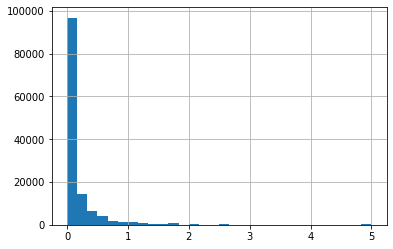

In [12]:
lklhd = hotel_booking_likelihood(train)
x = lklhd['lklhd']
x.hist(bins=30)
lklhd['lklhd'].mean()


In [13]:
train_eng = features_engeneering(train)
test_eng = features_engeneering(test)

train_eng = train_eng.dropna(axis=1)

assert len(train_eng)==len(train)
assert len(test_eng)==len(test)

if perform_undersampling:
    train_eng = undersample(train_eng, keep_first_lines) 
    ## remove outliers from price
mask = train_eng['price_usd']<max_price_usd
train_eng = train_eng[mask]

a = set(train_eng.columns)
len(a)
b = set(test_eng.columns)
print(f'columns not in both sets {a-b}')




columns not in both sets {'click_bool', 'booking_bool', 'position'}


In [14]:
display(train_eng[['price_usd','booking_bool', 'price_order','price_per_country_median','price_per_query_max','price_per_person']].head(100))

,price_usd,booking_bool,price_order,price_per_country_median,price_per_query_max,price_per_person
0,602.77,0,0,119.0,602.77,150.6925
1,280.69,0,1,119.0,602.77,70.1725
2,210.84,0,2,119.0,602.77,52.7100
3,195.32,0,3,119.0,602.77,48.8300
4,191.44,0,4,119.0,602.77,47.8600
...,...,...,...,...,...,...
95,85.00,0,9,119.0,153.00,42.5000
96,85.00,0,10,119.0,153.00,42.5000
97,84.00,0,11,119.0,153.00,42.0000
98,84.00,0,12,119.0,153.00,42.0000


### Choose features to fit

In [15]:
print(train_eng.columns)#  the columns after droping


features_to_choose = [#'srch_id', 
                      #'date_time',
                      #'site_id',
                      'visitor_location_country_id',
                      'prop_country_id',
                      'prop_id',
                      'prop_starrating',
    
                      'prop_review_score',
                      'prop_brand_bool',
                      'prop_location_score1',
                      'prop_location_score2',
                      'prop_log_historical_price',
                      #'position',
                      'price_usd',
                      'promotion_flag',
                      'srch_destination_id',
                      'srch_length_of_stay',
                      'srch_booking_window',
                      'srch_adults_count',
                      'srch_children_count',
                      'srch_room_count',
                      'srch_saturday_night_bool',
                      'orig_destination_distance',
                      'random_bool',
                      #'click_bool',
                      #'gross_bookings_usd',
                      #'booking_bool',
                      #'location_score',
                      #'historical_price',
                      #'price_per_country_median',
                      #'price_per_person'
                       #'price_order',
                       #'lklhd'
                        ]                        


Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_brand_bool', 'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'orig_destination_distance', 'random_bool',
       'click_bool', 'booking_bool', 'price_order', 'price_per_country_median',
       'price_per_query_max', 'price_per_person'],
      dtype='object')


In [16]:
#from mlxtend.frequent_patterns import apriori
#from mlxtend.frequent_patterns import association_rules
#frequent_itemsets= apriori(df[['promotion_flag','srch_saturday_night_bool', 'random_bool', 'click_bool', 'booking_bool']], min_support=0.07, use_colnames=True)
#rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
#rules = rules.sort_values(by=[ 'support', 'confidence',], ascending=False)

#rules[['antecedents', 'consequents','support','confidence']].iloc[0:10]


## Test and Evaluate

In [17]:
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Fit regression model
#model = linear_model.LinearRegression()
#n_neighbors = 10
#model = neighbors.KNeighborsRegressor(n_neighbors)
#model= DecisionTreeRegressor(random_state=0)
#model = GradientBoostingRegressor(random_state=0)

########       Cross EVALUATION           ###############

"""
size = 0.05

train_idx = int(len(train_eng)*1/2)
evaluation_size = int(train_idx*size)

X_train = train_eng.iloc[0:(train_idx-evaluation_size), :]
X_eval = train_eng.iloc[(train_idx-evaluation_size):train_idx, :]
X_test = train_eng.iloc[train_idx:, :]
"""


search_id = train_eng[['srch_id']]
search_id = search_id.drop_duplicates()
X_train, X_test = train_test_split(search_id, test_size=0.5, random_state=42)
X_train, X_eval = train_test_split(X_train, test_size=0.05, random_state=42)

X_train = X_train.merge(train_eng, how='left', left_on='srch_id', right_on='srch_id')
X_eval = X_eval.merge(train_eng, how='left', left_on='srch_id', right_on='srch_id')
X_test = X_test.merge(train_eng, how='left', left_on='srch_id', right_on='srch_id')


### RandomForestRegressor

#### cross validation

cross_validation average 0.24944240746343183
The time of evaluation fit: 12.567596673965454
cross_validation average 0.31202038411122823
The time of evaluation fit: 20.14020276069641
cross_validation average 0.31902771583392603
The time of evaluation fit: 29.930341005325317
cross_validation average 0.31450721867875814
The time of evaluation fit: 35.402034521102905
exit before the end
Optimal depth: 7


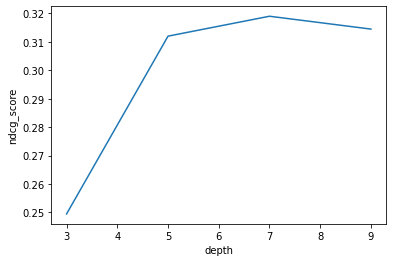

In [18]:
x = []
depth = [x for x in range(3,15) if x % 2 != 0]
prev_ndgc = 0
for i in depth:
    start = time.time()
    model = RandomForestRegressor(max_depth=i, random_state=0, n_jobs=-1)
    ndcg_score = my_cross_validation(model, X=X_eval, features_to_choose=features_to_choose, n_splits=number_of_splits)
    end = time.time()
    print("The time of evaluation fit:", end-start)
    x.append(ndcg_score)
    if ndcg_score<prev_ndgc:
        print('exit before the end')
        break    # break here
    prev_ndgc=ndcg_score
    
optimal_score_index = x.index(max(x))
optimal_depth = depth[optimal_score_index]
print(f'Optimal depth: {optimal_depth}')
plt.plot(depth[0:len(x)], x)
plt.xlabel('depth')
plt.ylabel('ndcg_score')
plt.show()

### GradientBoostingRegressor

cross_validation average 0.23609380269015562
The time of evaluation fit: 5.637956857681274
cross_validation average 0.2705181827002218
The time of evaluation fit: 10.23523736000061
cross_validation average 0.31577197439312
The time of evaluation fit: 19.47830581665039
cross_validation average 0.33132159483281826
The time of evaluation fit: 28.658432006835938
cross_validation average 0.33464608503458126
The time of evaluation fit: 35.40306067466736
cross_validation average 0.336920142758927
The time of evaluation fit: 52.749717235565186
cross_validation average 0.3401528637186094
The time of evaluation fit: 61.092759132385254
cross_validation average 0.340368027912653
The time of evaluation fit: 80.18586897850037
cross_validation average 0.3401191906025206
The time of evaluation fit: 88.74714827537537
exit before the end
Optimal n estimators: 90


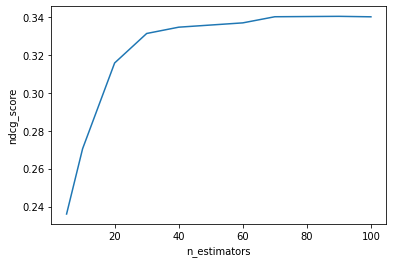

In [19]:
x = []
n_estimators = [5, 10, 20, 30, 40, 60, 70, 90, 100, 110, 120, 130]
prev_ndgc = 0
for i in n_estimators:
    start = time.time()
    model = GradientBoostingRegressor(n_estimators = i, random_state=0)
    ndcg_score = my_cross_validation(model, X_eval, \
                features_to_choose, n_splits=number_of_splits)
    end = time.time()
    print("The time of evaluation fit:", end-start)
    x.append(ndcg_score)
    if ndcg_score<prev_ndgc:
        print('exit before the end')
        break    # break here
    prev_ndgc=ndcg_score
    
optimal_score_index = x.index(max(x))
optimal_n = n_estimators[optimal_score_index]
print(f'Optimal n estimators: {optimal_n}')
plt.plot(n_estimators[0:len(x)], x)
plt.xlabel('n_estimators')
plt.ylabel('ndcg_score')
plt.show()


### Testing Random Forest

In [ ]:
##
start = time.time()
model = RandomForestRegressor(max_depth=optimal_depth, random_state=0, n_jobs=-1)
ndcg_score = evaluate_model(model, X_train, X_test, features_to_choose)
end = time.time()
print(f'Validation time and score RandomForestRegressor: {end-start}, {ndcg_score}')



### Testing Gradient Boosting

In [ ]:
start = time.time()
model = GradientBoostingRegressor(n_estimators=optimal_n, random_state=0)
ndcg_score = evaluate_model(model, X_train, X_test, features_to_choose)
end = time.time()
print(f'Validation time and score GradientBoostingRegressor: {end-start}, {ndcg_score}')


## Fit and submit 

In [ ]:
assert perform_submission

### GradientBoostingRegressor

In [ ]:
start = time.time()
model = GradientBoostingRegressor(n_estimators=optimal_n, random_state=0)
raitings = my_fit_and_predict(model, train_eng, test_eng, features_to_choose)
end = time.time()
print("The time of final fit GradientBoostingRegressor:", end-start)
create_submission(test_eng, raitings, 'GradientBoostingRegressor')
assert len(raitings)==len(test)
features_to_choose

### RandomForestRegressor

In [ ]:
start = time.time()
model = RandomForestRegressor(max_depth=optimal_depth, random_state=0, n_jobs=-1)
raitings = my_fit_and_predict(model, train_eng, test_eng, features_to_choose)
end = time.time()
print("The time of final fit RandomForestRegressor:", end-start)
create_submission(test_eng, raitings, 'RandomForestRegressor')
assert len(raitings)==len(test)
features_to_choose

In [ ]:
len(raitings)

In [ ]:
display(raitings)

In [ ]:
features_to_choose